In [1]:
import os
import cv2
import random
import numpy as np
import datetime as dt

from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

C:\Users\dell\AppData\Local\Temp\ipykernel_15072\612589392.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [44]:
# Classes Directories
NonViolnceVideos_Dir = "dataset/NonViolence"
ViolnceVideos_Dir = "dataset/Violence"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [2]:
#ify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16
 

DATASET_DIR = "dataset"
 
CLASSES_LIST = ["NonViolence","Violence"]
print("hi")

hi


In [3]:
def frames_extraction(video_path):
 
    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
 
    video_reader.release()
 
    return frames_list
print("hi")

hi


In [4]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [5]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [6]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [7]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

In [8]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [9]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [10]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(793, 16, 64, 64, 3) (793, 2)
(89, 16, 64, 64, 3) (89, 2)


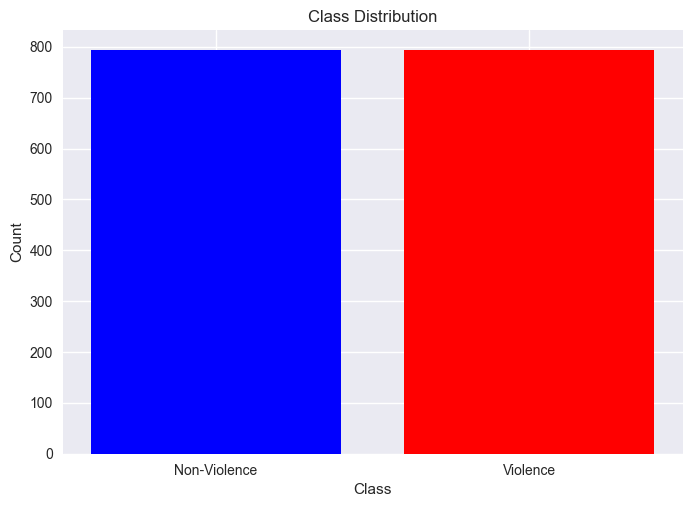

In [54]:
import matplotlib.pyplot as plt

# Function to plot bar chart showing class distribution for both classes
def plot_class_distribution(labels, class_names):
    non_violence_count = np.sum(labels == class_names.index("NonViolence"))
    violence_count = np.sum(labels == class_names.index("Violence"))
    
    plt.bar(["Non-Violence", "Violence"], [non_violence_count, violence_count], color=['blue', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

# Plot class distribution for both classes
plot_class_distribution(labels_train, class_names=CLASSES_LIST)


In [11]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

#mobilenet.summary()

In [12]:
def create_model():
    model = Sequential()
    #######################################################################################################################
    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  
    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    model.add(Dropout(0.25))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    #######################################################################################################################
    model.summary()
    
    return model
print("hi")

hi


In [13]:
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [14]:

import tensorflow as tf
from keras.callbacks import EarlyStopping

# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=5,
    min_lr=0.00005,
    verbose=1
)

# Compiling the model
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

# Fitting the model
MobBiLSTM_model_history = MoBiLSTM_model.fit(
    x=features_train,
    y=labels_train,
    epochs=20,
    batch_size=8,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback, reduce_lr]
)

Epoch 1/20
80/80 [==============================] - 129s 1s/step - loss: 0.6890 - accuracy: 0.5079 - val_loss: 0.6863 - val_accuracy: 0.5786 - lr: 0.0100
Epoch 2/20
80/80 [==============================] - 66s 825ms/step - loss: 0.6836 - accuracy: 0.5426 - val_loss: 0.6875 - val_accuracy: 0.5535 - lr: 0.0100
Epoch 3/20
80/80 [==============================] - 72s 904ms/step - loss: 0.6781 - accuracy: 0.5647 - val_loss: 0.6788 - val_accuracy: 0.6164 - lr: 0.0100
Epoch 4/20
80/80 [==============================] - 89s 1s/step - loss: 0.6408 - accuracy: 0.6435 - val_loss: 0.5915 - val_accuracy: 0.7736 - lr: 0.0100
Epoch 5/20
80/80 [==============================] - 93s 1s/step - loss: 0.5607 - accuracy: 0.7334 - val_loss: 0.4513 - val_accuracy: 0.8113 - lr: 0.0100
Epoch 6/20
80/80 [==============================] - 102s 1s/step - loss: 0.4730 - accuracy: 0.8233 - val_loss: 0.3844 - val_accuracy: 0.8428 - lr: 0.0100
Epoch 7/20
80/80 [==============================] - 77s 958ms/step - loss:

In [15]:
MoBiLSTM_model.save("model.h5")

model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 4s 1s/step - loss: 0.2762 - accuracy: 0.9326


In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

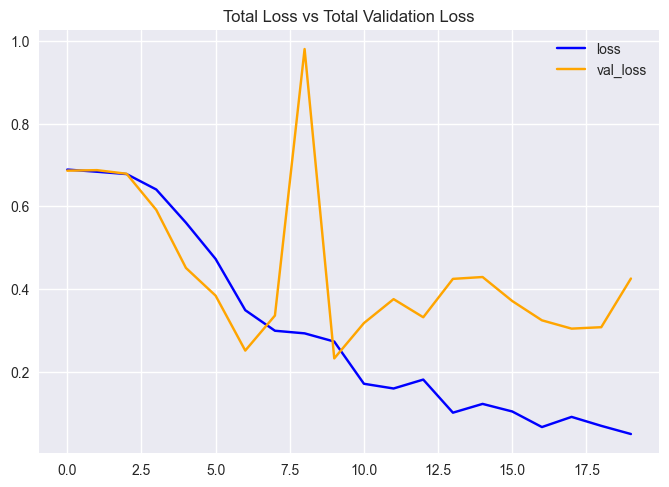

In [17]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

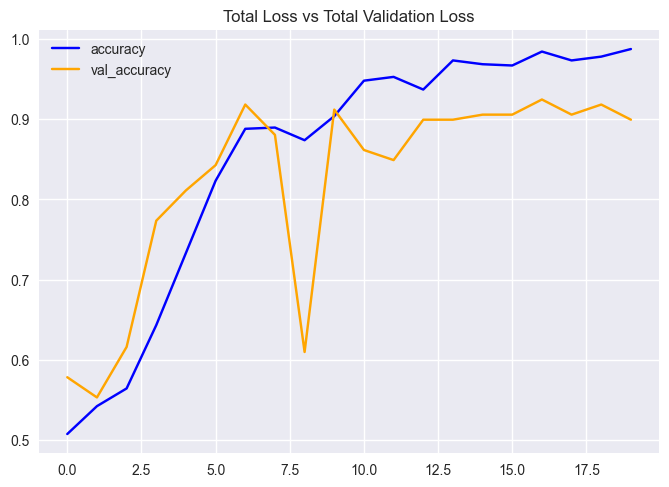

In [18]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [19]:
labels_predict = MoBiLSTM_model.predict(features_test)

3/3 [==============================] - 12s 1s/step


In [20]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [21]:
labels_test_normal.shape , labels_predict.shape

((89,), (89,))

In [22]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9325842696629213


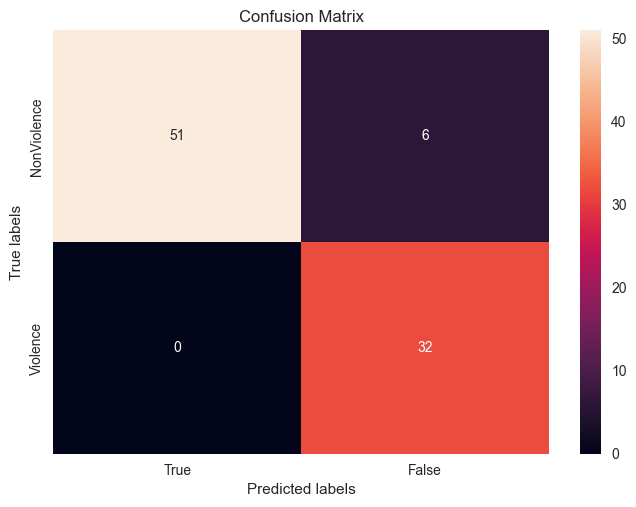

In [23]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [24]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        57
           1       0.84      1.00      0.91        32

    accuracy                           0.93        89
   macro avg       0.92      0.95      0.93        89
weighted avg       0.94      0.93      0.93        89



In [66]:
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Input, TimeDistributed, Dropout, Flatten, Bidirectional, LSTM, Dense

# Load EfficientNetB0 model from Keras Applications
CLASSES_LIST = ["NonViolence","Violence"]
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH=16
efficientnet = EfficientNetB0(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, weights='imagenet', input_tensor=Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

# Fine-tuning to make the last few layers trainable
efficientnet.trainable = True

for layer in efficientnet.layers[:-10]:  # Adjust the number of layers to fine-tune
    layer.trainable = False

# Create the model
def create_model():
    model = Sequential()

    # Specifying Input to match features shape
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Passing EfficientNetB0 in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(efficientnet))

    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)

    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

# Create the model using EfficientNetB0
efficientnet_model = create_model()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, 16, 2, 2, 1280)    4049571   
 istributed)                                                     
                                                                 
 dropout_36 (Dropout)        (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_13 (TimeD  (None, 16, 5120)          0         
 istributed)                                                     
                                                                 
 bidirectional_6 (Bidirecti  (None, 64)                1319168   
 onal)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                      

In [67]:
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Compile the model
efficientnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Split the Data into Train (90%) and Test Set (10%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1, shuffle=True, random_state=42)

# Train the model
efficientnet_model.fit(features_train, labels_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
evaluation = efficientnet_model.evaluate(features_test, labels_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

# Save the model if needed
efficientnet_model.save("efficientnet_model.h5")


Epoch 1/20
23/23 [==============================] - 156s 5s/step - loss: 0.7017 - accuracy: 0.5035 - val_loss: 0.6834 - val_accuracy: 0.6000
Epoch 2/20
23/23 [==============================] - 98s 4s/step - loss: 0.6947 - accuracy: 0.5077 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 3/20
23/23 [==============================] - 92s 4s/step - loss: 0.6962 - accuracy: 0.5161 - val_loss: 0.6865 - val_accuracy: 0.6000
Epoch 4/20
23/23 [==============================] - 88s 4s/step - loss: 0.6983 - accuracy: 0.4937 - val_loss: 0.6950 - val_accuracy: 0.4000
Epoch 5/20
23/23 [==============================] - 88s 4s/step - loss: 0.6920 - accuracy: 0.5133 - val_loss: 0.6820 - val_accuracy: 0.6000
Epoch 6/20
23/23 [==============================] - 87s 4s/step - loss: 0.6988 - accuracy: 0.5133 - val_loss: 0.6859 - val_accuracy: 0.6000
Epoch 7/20
23/23 [==============================] - 87s 4s/step - loss: 0.6936 - accuracy: 0.5231 - val_loss: 0.6862 - val_accuracy: 0.6000
Epoch 8/20
23/23 [=

C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
import cv2
import numpy as np
from collections import deque
!pip install simpleaudio
import simpleaudio as sa


def generate_alarm_tone(duration_seconds=1):
    sample_rate = 44100  # Sample rate in Hz
    frequency = 440  # Alarm tone frequency in Hz
    t = np.linspace(0, duration_seconds, int(sample_rate * duration_seconds), endpoint=False)
    alarm_tone = 0.5 * np.sin(2 * np.pi * frequency * t)
    return (alarm_tone * 32767).astype(np.int16)

def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
 
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame 
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis=0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
            # Generate and play the alarm tone
            alarm_tone = generate_alarm_tone()
            sa.play_buffer(alarm_tone, 1, 2, 44100)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import matplotlib.pyplot as plt

# Train the ensemble model
ensemble_model_history = ensemble_model.fit(
    x=[features_train, features_train],  # Use the same input for both models
    y=labels_train,
    epochs=20,  # Adjust the number of epochs as needed
    batch_size=8,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback, reduce_lr]
)

# Save accuracy
accuracy = ensemble_model_history.history['accuracy'][-1]
with open('ensemble_accuracy.txt', 'w') as f:
    f.write(str(accuracy))

# Plot training and validation accuracy
plt.plot(ensemble_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(ensemble_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Ensemble Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('ensemble_accuracy_plot.png')
plt.show()

# Plot training and validation loss
plt.plot(ensemble_model_history.history['loss'], label='Training Loss')
plt.plot(ensemble_model_history.history['val_loss'], label='Validation Loss')
plt.title('Ensemble Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('ensemble_loss_plot.png')
plt.show()


NameError: name 'ensemble_model' is not defined

3/3 [==============================] - 18s 3s/step
Confusion Matrix:
[[57  0]
 [32  0]]


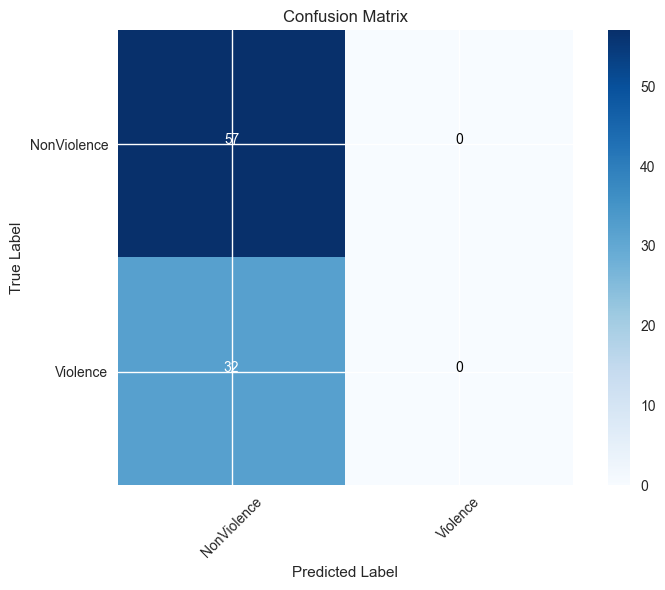

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict probabilities for each class
y_pred_probs = ensemble_model.predict([features_test, features_test])

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(labels_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(CLASSES_LIST)), CLASSES_LIST, rotation=45)
plt.yticks(np.arange(len(CLASSES_LIST)), CLASSES_LIST)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(len(CLASSES_LIST)):
    for j in range(len(CLASSES_LIST)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
    


C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.64      1.00      0.78        57
    Violence       0.00      0.00      0.00        32

    accuracy                           0.64        89
   macro avg       0.32      0.50      0.39        89
weighted avg       0.41      0.64      0.50        89



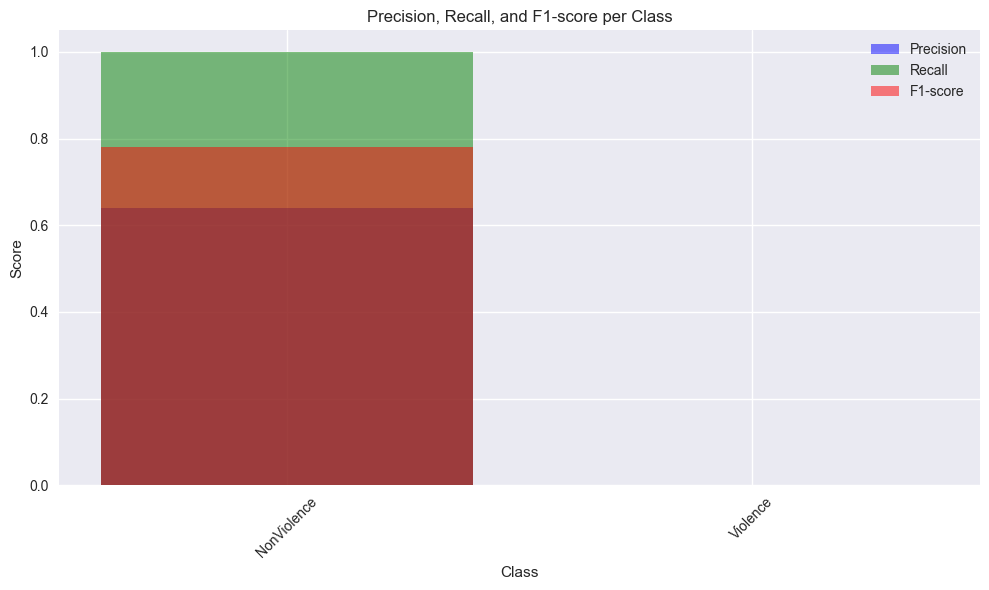

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_true_labels, y_pred_labels, target_names=CLASSES_LIST)

# Print classification report
print("Classification Report:")
print(class_report)

# Save classification report to a file
with open('classification_report.txt', 'w') as f:
    f.write(class_report)

# Plot precision, recall, and F1-score
report_dict = classification_report(y_true_labels, y_pred_labels, target_names=CLASSES_LIST, output_dict=True)
precisions = [report_dict[label]['precision'] for label in CLASSES_LIST]
recalls = [report_dict[label]['recall'] for label in CLASSES_LIST]
f1_scores = [report_dict[label]['f1-score'] for label in CLASSES_LIST]

plt.figure(figsize=(10, 6))
plt.bar(CLASSES_LIST, precisions, color='b', alpha=0.5, label='Precision')
plt.bar(CLASSES_LIST, recalls, color='g', alpha=0.5, label='Recall')
plt.bar(CLASSES_LIST, f1_scores, color='r', alpha=0.5, label='F1-score')
plt.title('Precision, Recall, and F1-score per Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('precision_recall_f1.png')
plt.show()


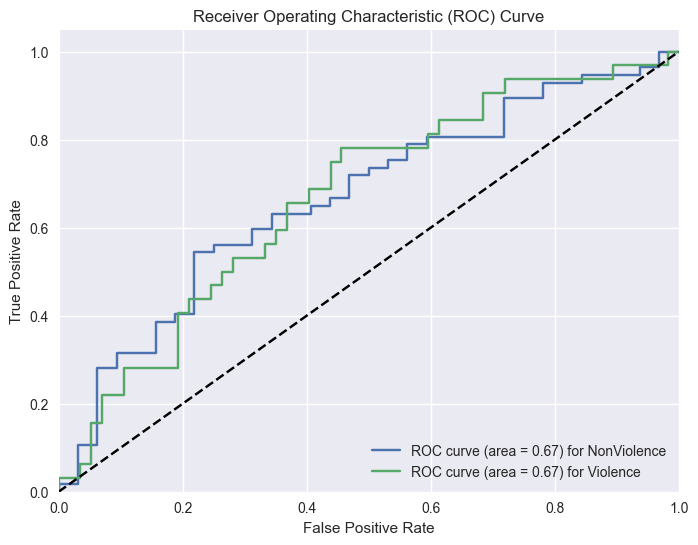

In [ ]:


from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(CLASSES_LIST)):
    fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(CLASSES_LIST)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], CLASSES_LIST[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()


In [32]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path): 

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.  
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
          
        ok, frame = video_reader.read() 

        if not ok:
          break 

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()
                            
    video_reader.release()

In [33]:
# Construct the output video path.
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
    
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'


1/1 [==============================] - 0s 95ms/step
hiiii 66


C:\Users\dell\AppData\Local\Temp\ipykernel_15072\3820068190.py:30: UserWarning: The figure layout has changed to tight
  plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()


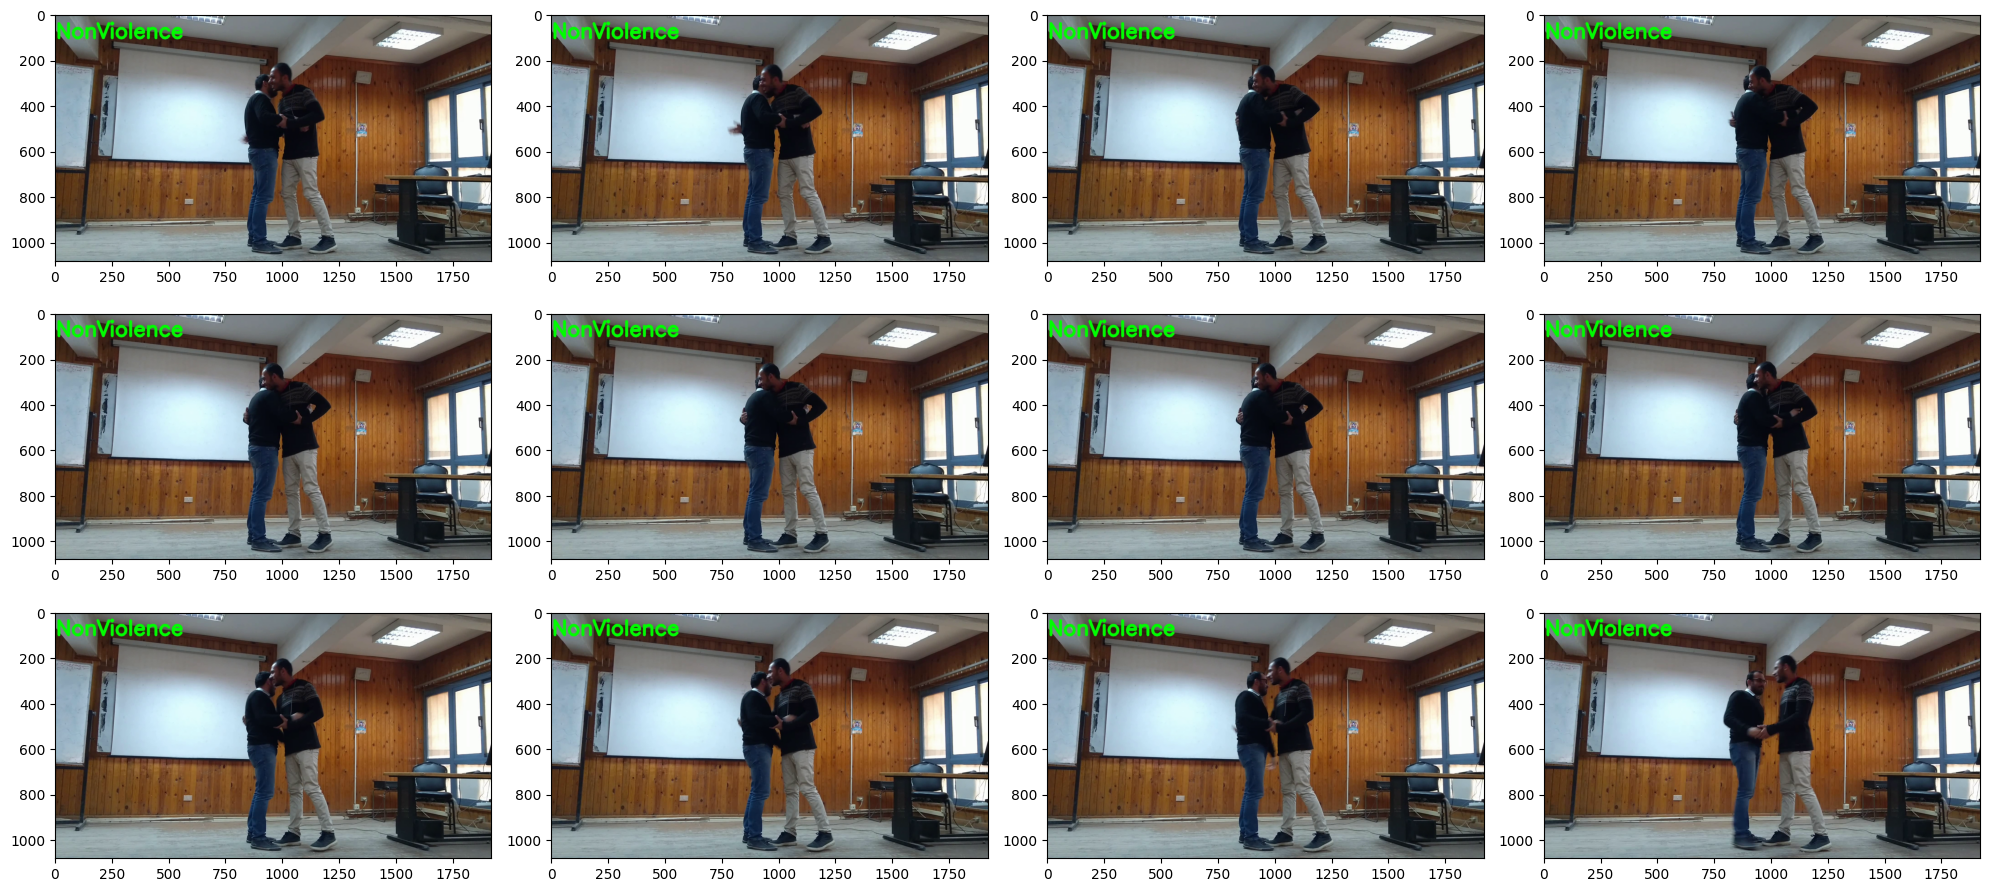

In [36]:
# Specifying video to be predicted
input_video_file_path = "dataset/NonViolence/NV_1.mp4"

predict_frames(input_video_file_path, output_video_file_path, 16)

# Show random frames from the output video
show_pred_frames(output_video_file_path)




In [ ]:
import numpy as np

# Predictions from MoBiLSTM_model and efficientnet_model
predictions_mobilenet = MoBiLSTM_model.predict(features_test)
predictions_efficientnet = efficientnet_model.predict(features_test)

# Combine predictions by averaging
ensemble_predictions = (predictions_mobilenet + predictions_efficientnet) / 2

# Get the class with the highest probability for each sample
ensemble_labels = np.argmax(ensemble_predictions, axis=1)

# Evaluate the ensemble model
ensemble_evaluation = accuracy_score(ensemble_labels, labels_test_normal)
print('Ensemble Model Accuracy Score is:', ensemble_evaluation)

3/3 [==============================] - 14s 2s/step
Ensemble Model Accuracy Score is: 0.6404494382022472


In [ ]:
from keras.models import load_model

# Load the models
model1 = load_model("C:/Users/dell/Documents/GitHub/TrafficAnomaly-Detection/AccidentDetectionModel.h5")
model2 = load_model("efficientnet_model.h5")


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:
batch_size = 100
img_height = 300
img_width = 300


In [ ]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '',
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Dataset/Accident Detection From CCTV Footage/data/test/',
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
 '../Dataset/Accident Detection From CCTV Footage/data/val/',
    image_size= (img_height, img_width),
    batch_size=batch_size)

NotFoundError: Could not find directory ../Dataset/Accident Detection From CCTV Footage/data/train/

In [ ]:
# Assuming you have your input data for each model stored in variables named 'data1' and 'data2'
data1 = training_ds  # Use the training dataset for accident detection as data1

# Define a function to combine the predictions of both models
def combined_prediction(data1, data2):
    # Make predictions using each model on their respective data
    predictions1 = model1.predict(data1)
    predictions2 = model2.predict(data2)
    
    # Combine predictions from both models
    return (predictions1 + predictions2) / 2

# Now you can call this function with your input data for each model to get the combined predictions
combined_predictions = combined_prediction(data1, data2)


NameError: name 'training_ds' is not defined